# Exploratory Data Analysis 

In [224]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import us
import seaborn as sns

## Global Gas Flaring Estimates — Remotely Sensed VIIRS Nightfire Combustion



In [217]:
viirs = pd.read_csv('../data/input/viirs/VNF_npp_d20171201_noaa_v30-ez.csv')

viirs.columns = [c.lower() for c in viirs.columns]

viirs.head(3)

,id,id_key,date_proc,lat_gmtco,lon_gmtco,date_mscan,date_ltz,temp_bb,temp_bkg,esf_bb,...,cloud_mask,qf_fit,qf_detect,sample_m10,line_m10,sample_dnb,line_dnb,file_m10,file_dnb,source_id
0,2,x1000966E_y503894N_l0030_s0792_v30,2017/12/05 11:45:51,50.389370,100.096634,2017/12/01 18:46:02.701,2017-12-02 02:46:02.701,967,249,0.000018,...,0,34,12848,792,30,1078,32,SVM10_npp_d20171201_t1846006_e1847248_b31587_c...,SVDNB_npp_d20171201_t1846006_e1847248_b31587_c...,NaN
1,3,x1001052E_y503926N_l0034_s0793_v30,2017/12/05 11:45:51,50.392555,100.105202,2017/12/01 18:46:04.480,2017-12-02 02:46:04.480,1016,249,0.000015,...,999999,34,13872,793,34,1079,31,SVM10_npp_d20171201_t1846006_e1847248_b31587_c...,SVDNB_npp_d20171201_t1846006_e1847248_b31587_c...,NaN
2,12,x1191472E_y459453N_l0238_s2461_v30,2017/12/05 11:45:51,45.945339,119.147217,2017/12/01 18:46:25.832,2017-12-02 02:46:25.832,986,249,0.000092,...,0,34,16241,2461,238,3063,240,SVM10_npp_d20171201_t1846006_e1847248_b31587_c...,SVDNB_npp_d20171201_t1846006_e1847248_b31587_c...,NaN


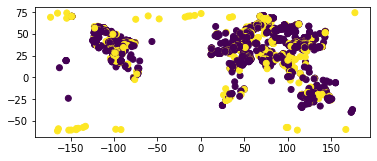

In [218]:
# From Noah's Local Folium Lesson 

## Create point geometries column
geom = [Point(xy) for xy in zip(viirs['lon_gmtco'], viirs['lat_gmtco'])]

## Set the coordinate reference system we'll be using. 
## EPSG:4326 is the CRS for the WGS1984 datum (standard for maps of the whole world)
crs = {'init':'epsg:4326'}
viirs_gdf = gpd.GeoDataFrame(viirs, crs =crs, geometry=geom)
viirs_gdf.plot(df_gpd['temp_bb'])

## US Census County Shapefiles

### Delineating EIA Basins

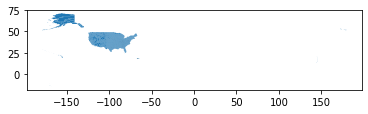

In [219]:
census = gpd.read_file('../data/input/census/tl_2017_us_county.shp')

census.columns = [c.lower() for c in census.columns]

census.plot()

In [113]:
census.head(2)

,statefp,countyfp,countyns,geoid,name,namelsad,lsad,classfp,mtfcc,csafp,cbsafp,metdivfp,funcstat,aland,awater,intptlat,intptlon,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477641638,10701538,+41.9158651,-096.7885168,"POLYGON ((-97.01952 42.00410, -97.01952 42.004..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680956787,61588406,+46.2946377,-123.4244583,"POLYGON ((-123.43639 46.23820, -123.44759 46.2..."


In [115]:
census.shape

(3233, 18)

In [ ]:
## US Energy  

## U.S. Energy Information Administration (EIA)

### County Basin Delineations Sheet

In [193]:
eia_cnty = pd.read_excel('../data/input/eia/dpr-data.xlsx', sheet_name='RegionCounties')

eia_cnty.columns = [c.lower() for c in eia_cnty.columns]

def remap_state_fips(state_abbrev):
    s = us.states.lookup(state_abbrev)
    return s.fips

eia_cnty['stateid'] = eia_cnty['state'].map(remap_state_fips)      

# eia_cnty['stateid'] = np.where(
#     eia_cnty['state'] == 'TX',
#     48,
#     eia_cnty['stateid'],
# )

# eia_cnty['stateid'] = np.where(
#     eia_cnty['state'] == 'OK',
#     40,
#     eia_cnty['stateid'],
# )

# eia_cnty['stateid'] = np.where(
#     eia_cnty['state'] == 'OH',
#     39,
#     eia_cnty['stateid'],
# )

# eia_cnty['stateid'] = np.where(
#     eia_cnty['state'] == 'OH',
#     39,
#     eia_cnty['stateid'],
# )


eia_cnty['geoid'] = eia_cnty['stateid'].astype(str).str.zfill(2) + eia_cnty['countyid'].astype(str).str.zfill(3)

eia_cnty

,state,county,stateid,countyid,region,geoid
0,OK,ALFALFA,40,3,Anadarko Region,40003
1,OK,BEAVER,40,7,Anadarko Region,40007
2,OK,BECKHAM,40,9,Anadarko Region,40009
3,OK,BLAINE,40,11,Anadarko Region,40011
4,OK,CADDO,40,15,Anadarko Region,40015
...,...,...,...,...,...,...
310,TX,UPTON,48,461,Permian Region,48461
311,TX,VAL VERDE,48,465,Permian Region,48465
312,TX,WARD,48,475,Permian Region,48475
313,TX,WINKLER,48,495,Permian Region,48495


In [194]:
eia_cnty = eia_cnty[['geoid', 'region', 'stateid', 'state']].copy()
eia_cnty

print(eia_cnty.shape)

eia_cnty

(315, 4)


,geoid,region,stateid,state
0,40003,Anadarko Region,40,OK
1,40007,Anadarko Region,40,OK
2,40009,Anadarko Region,40,OK
3,40011,Anadarko Region,40,OK
4,40015,Anadarko Region,40,OK
...,...,...,...,...
310,48461,Permian Region,48,TX
311,48465,Permian Region,48,TX
312,48475,Permian Region,48,TX
313,48495,Permian Region,48,TX


In [195]:
basins = pd.merge(left=census, right=eia_cnty, on='geoid', how='right')

basins[['region', 'geoid', 'statefp']].to_csv('../data/input/basins_test.csv', index=False)

basins.isnull().sum()

# So I'm still missing 48 Basins

statefp       0
countyfp      0
countyns      0
geoid         0
name          0
namelsad      0
lsad          0
classfp       0
mtfcc         0
csafp       231
cbsafp      154
metdivfp    314
funcstat      0
aland         0
awater        0
intptlat      0
intptlon      0
geometry      0
region        0
stateid       0
state         0
dtype: int64

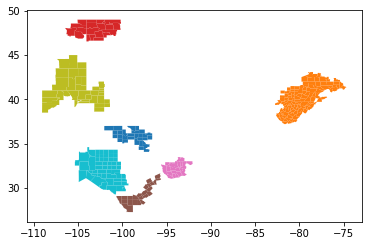

In [196]:
basins.plot(basins['region'])

In [197]:
x = basins[basins['statefp'].isnull()][['region', 'state', 'statefp','stateid']]
x.groupby(['region', 'stateid', 'state']).count()

,,,statefp
region,stateid,state,


In [198]:
texas = census[census['statefp'] == '42']

# TEXAS FID's are incorrect

# READ EIA DOCUMENTATION ABOUT STATE CODES


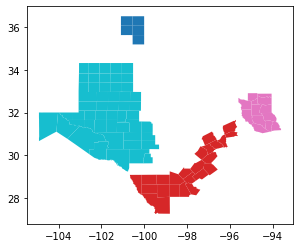

In [199]:
texas_basins = basins[basins['statefp'] == '48']
texas_basins.plot(texas_basins['region'])

In [200]:
census.describe()

,aland,awater
count,3.233000e+03,3.233000e+03
mean,2.832999e+09,2.262071e+08
std,9.239455e+09,1.366531e+09
min,8.209300e+04,0.000000e+00
25%,1.078539e+09,7.047471e+06
50%,1.562337e+09,1.951985e+07
75%,2.367401e+09,6.202152e+07
max,3.770309e+11,3.539027e+10


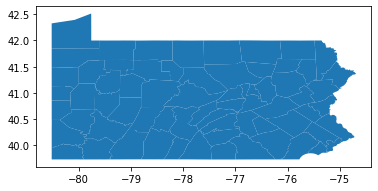

In [201]:
texas.plot()

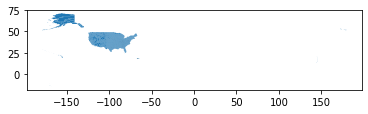

In [202]:
census.plot()

In [203]:
census['statefp'].value_counts() #.sort_index()

48    254
13    159
51    133
21    120
29    115
20    105
17    102
37    100
19     99
47     95
31     93
18     92
39     88
27     87
26     83
28     82
72     78
40     77
05     75
55     72
01     67
42     67
12     67
46     66
22     64
08     64
36     62
06     58
30     56
54     55
38     53
45     46
16     44
53     39
41     36
35     33
49     29
02     29
24     24
56     23
34     21
32     17
23     16
04     15
25     14
50     14
33     10
09      8
44      5
60      5
15      5
69      4
78      3
10      3
66      1
11      1
Name: statefp, dtype: int64

In [204]:
texas = census[census['statefp'] == '48']


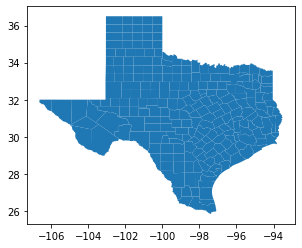

In [205]:
texas.plot()

In [206]:
texas.shape

(254, 18)

In [207]:
census['statefp'].unique()

array(['31', '53', '35', '72', '46', '48', '06', '21', '39', '01', '13',
       '55', '05', '41', '42', '28', '29', '08', '37', '49', '40', '51',
       '47', '56', '54', '22', '36', '26', '18', '25', '20', '16', '12',
       '02', '78', '32', '17', '50', '09', '30', '34', '27', '38', '24',
       '19', '45', '23', '15', '33', '04', '10', '11', '66', '69', '60',
       '44'], dtype=object)

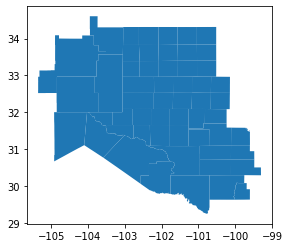

In [211]:
permian_basin = basins[
    (basins['region'] == 'Permian Region')#  & (basins['statefp'] == '48')
]
#df_gpd.plot()
permian_basin.plot()


In [209]:
# Look up Geopandas code for intersect and do here for
# permian_basn and df_gpd = viirs_nightfire

In [212]:
# Google EIA STATE FIPS CODES???!!!???



/Users/danielmsheehan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4269'})
  "(%s != %s)" % (left_df.crs, right_df.crs)


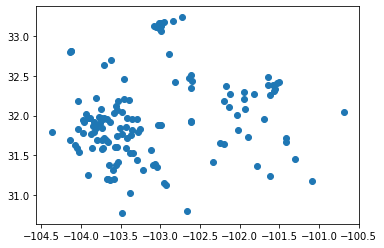

In [221]:
basin_viirs = gpd.sjoin(
    viirs_gdf, 
    permian_basin, 
    how="inner", 
    op='intersects',  # warning CRS of frames do not match
)

basin_viirs.plot('')


In [222]:
basin_viirs

,id,id_key,date_proc,lat_gmtco,lon_gmtco,date_mscan,date_ltz,temp_bb,temp_bkg,esf_bb,...,cbsafp,metdivfp,funcstat,aland,awater,intptlat,intptlon,region,stateid,state
3270,6,x1027334W_y332399N_l0122_s1680_v30,2017/12/05 11:11:26,33.239876,-102.733398,2017/12/01 08:41:39.394,2017-12-01 02:41:39.394,999999,999999,9.999990e+05,...,None,None,A,2071252452,34329,+33.1623979,-102.8322422,Permian Region,48,TX
3271,8,x1028439W_y331970N_l0131_s1669_v30,2017/12/05 11:11:26,33.196999,-102.843857,2017/12/01 08:41:41.174,2017-12-01 02:41:41.174,999999,999999,9.999990e+05,...,None,None,A,2071252452,34329,+33.1623979,-102.8322422,Permian Region,48,TX
3272,9,x1029581W_y331812N_l0136_s1656_v30,2017/12/05 11:11:26,33.181236,-102.958061,2017/12/01 08:41:41.174,2017-12-01 02:41:41.174,1942,999999,9.912970e-07,...,None,None,A,2071252452,34329,+33.1623979,-102.8322422,Permian Region,48,TX
3274,11,x1030117W_y331694N_l0139_s1650_v30,2017/12/05 11:11:26,33.169373,-103.011726,2017/12/01 08:41:41.174,2017-12-01 02:41:41.174,999999,999999,9.999990e+05,...,None,None,A,2071252452,34329,+33.1623979,-102.8322422,Permian Region,48,TX
3275,12,x1029953W_y331667N_l0139_s1652_v30,2017/12/05 11:11:26,33.166748,-102.995338,2017/12/01 08:41:41.174,2017-12-01 02:41:41.174,1884,999999,1.367510e-06,...,None,None,A,2071252452,34329,+33.1623979,-102.8322422,Permian Region,48,TX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3403,215,x1010903W_y311787N_l0383_s1934_v30,2017/12/05 11:11:26,31.178715,-101.090324,2017/12/01 08:42:07.863,2017-12-01 02:42:07.863,999999,999999,9.999990e+05,...,41660,None,A,2723485996,176317,+31.3034241,-100.9813037,Permian Region,48,TX
3424,250,x1029588W_y311501N_l0435_s1726_v30,2017/12/05 11:11:26,31.150082,-102.958809,2017/12/01 08:42:14.980,2017-12-01 02:42:14.980,1730,999999,2.546700e-06,...,None,None,A,12338274939,2532275,+30.7708943,-102.7198600,Permian Region,48,TX
3425,251,x1029293W_y311315N_l0437_s1730_v30,2017/12/05 11:11:26,31.131470,-102.929283,2017/12/01 08:42:14.980,2017-12-01 02:42:14.980,1814,999999,1.707370e-06,...,None,None,A,12338274939,2532275,+30.7708943,-102.7198600,Permian Region,48,TX
3434,264,x1026627W_y308005N_l0479_s1772_v30,2017/12/05 11:11:26,30.800474,-102.662666,2017/12/01 08:42:18.538,2017-12-01 02:42:18.538,2157,999999,2.746950e-07,...,None,None,A,12338274939,2532275,+30.7708943,-102.7198600,Permian Region,48,TX


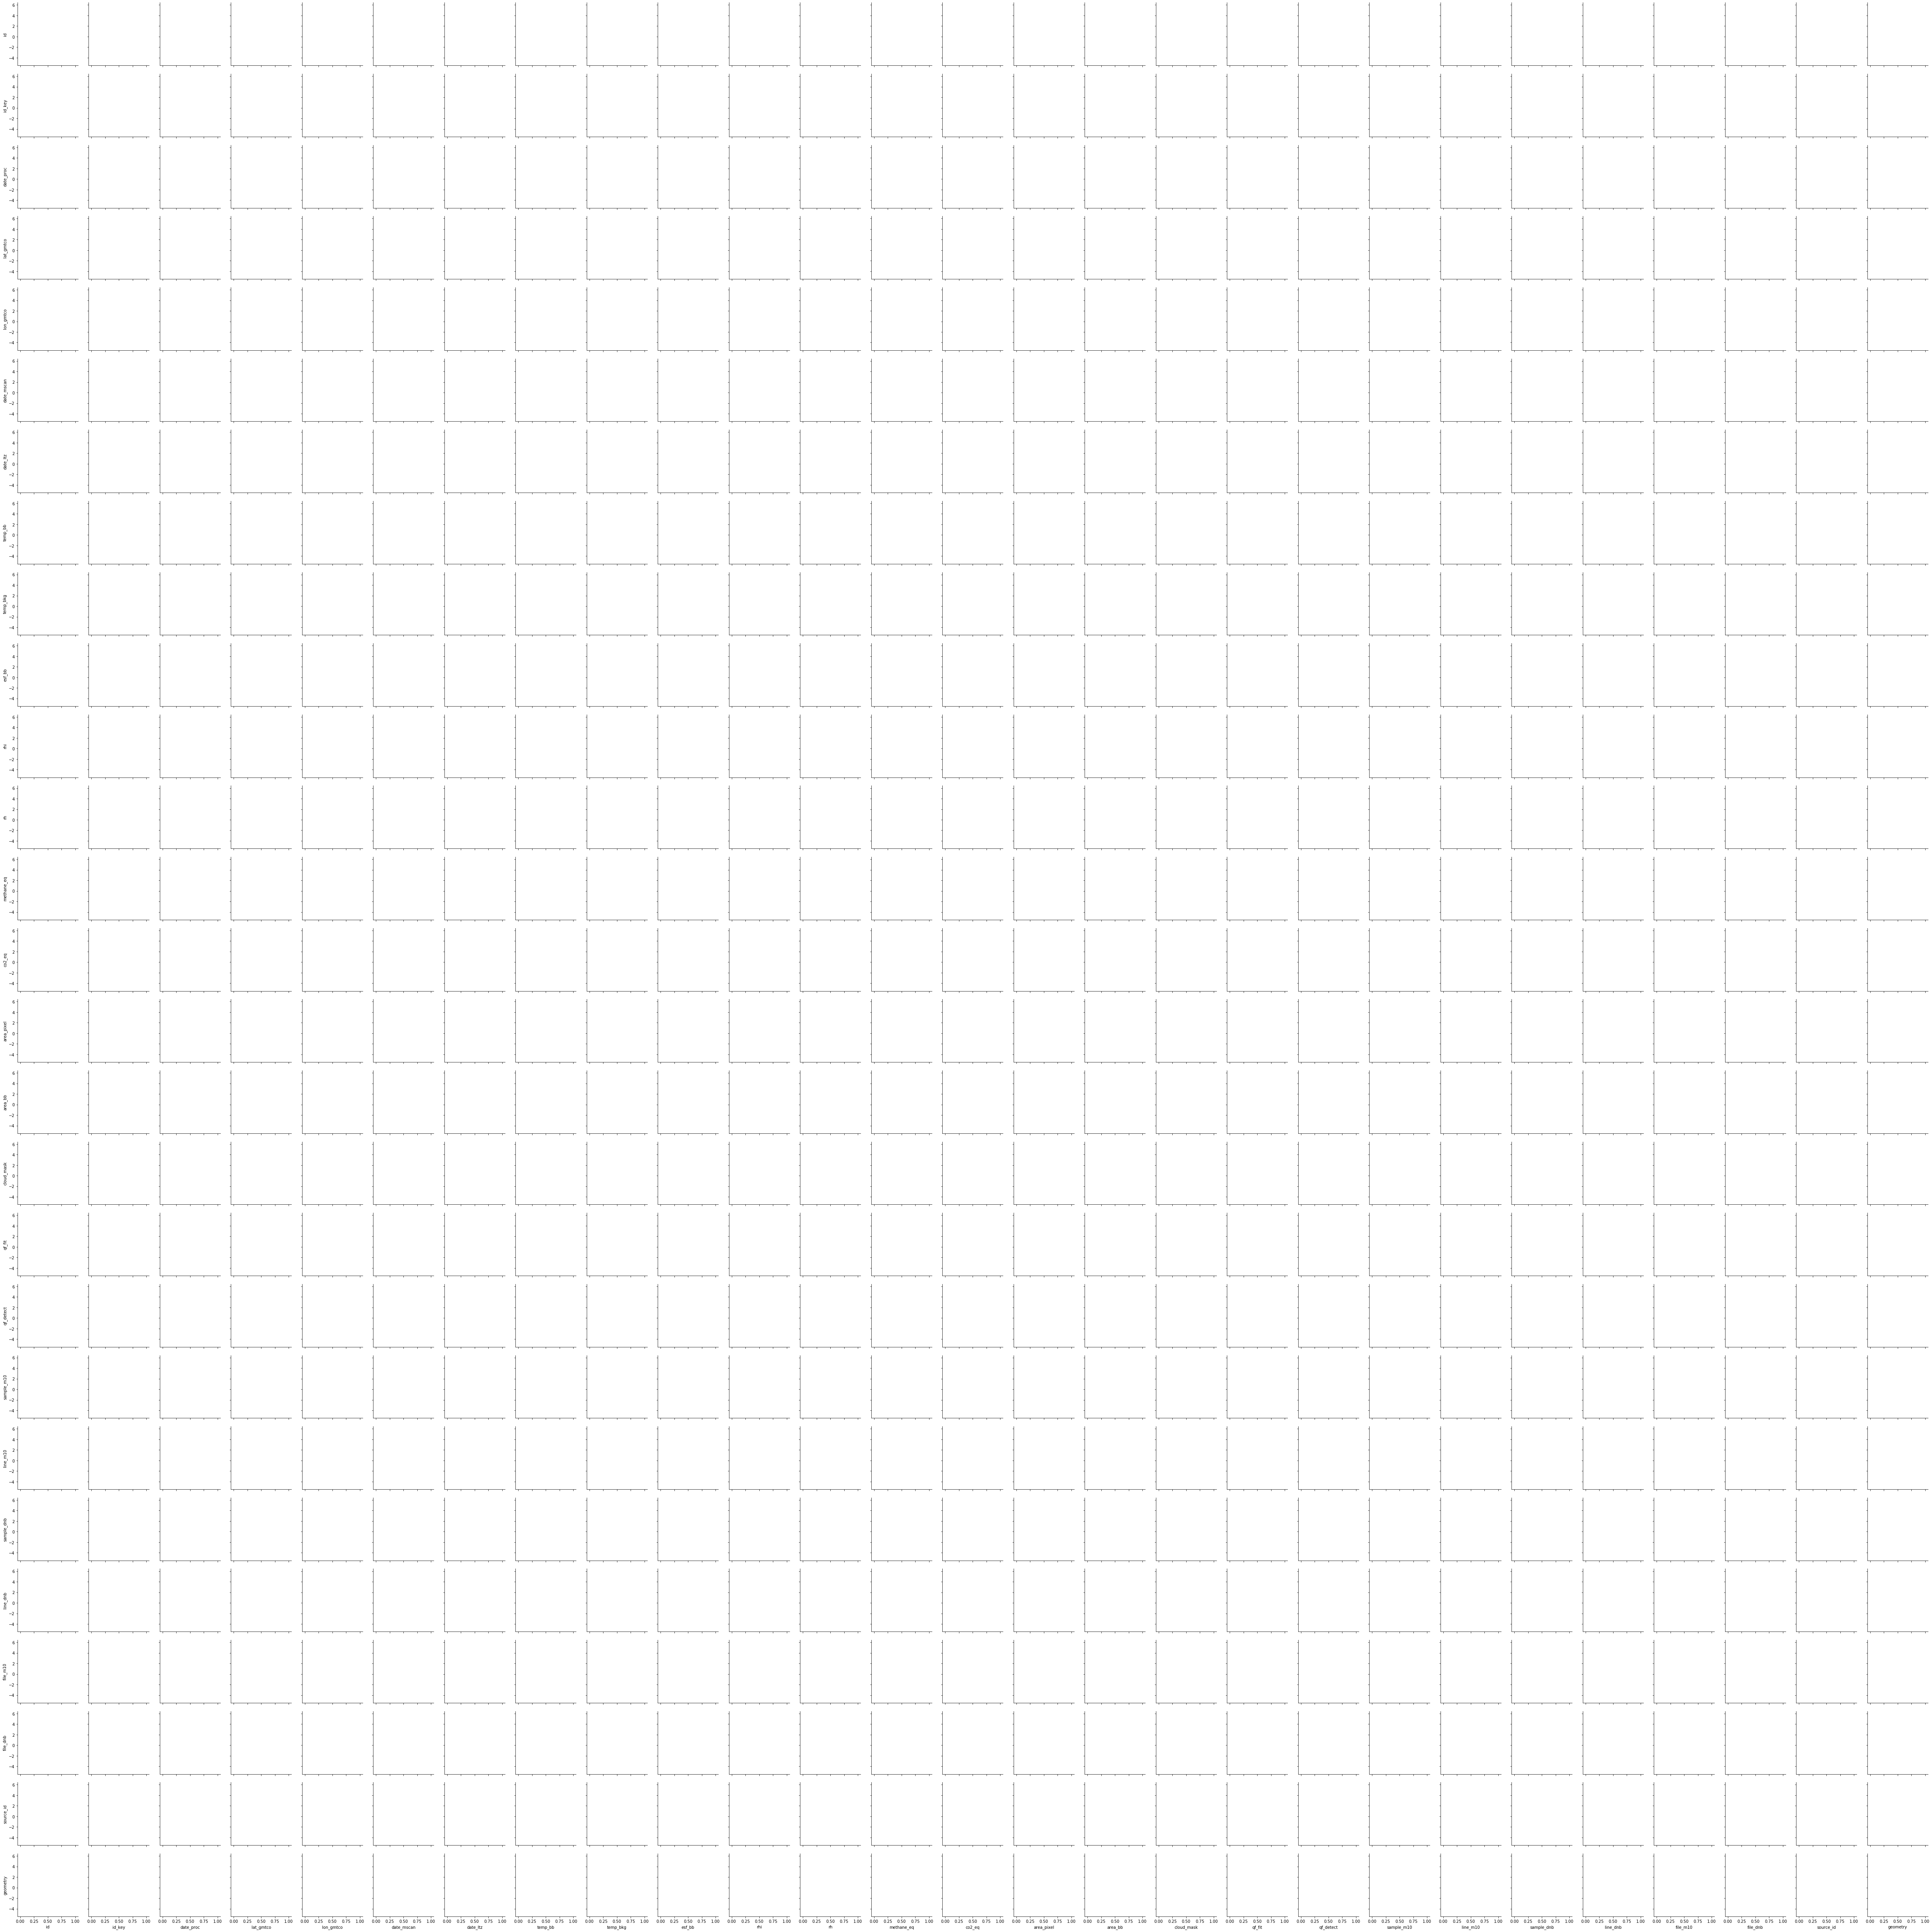

In [228]:
sns.pairplot(
    viirs.dropna()
)  # maybe try w/ basin_viirs

## Creating VIIRS Nightfire Combustion Sources Geographic Aggregation Metrics